## Loading the libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from datetime import datetime, timedelta

## Importing the dataset

In [16]:
boston_df = pd.read_csv('../Datasets/boston_house_prices.csv')

## Dataset Info - Missing values 

In [17]:
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [18]:
boston_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Advanced EDA Concepts and Investigation

### Structure investigation

In [19]:
print("Numerical Features:")
print(boston_df.select_dtypes(include=[np.number]).columns.tolist())
print("\nCategorical Features:")
print(boston_df.select_dtypes(exclude=[np.number]).columns.tolist())



Numerical Features:
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

Categorical Features:
[]


## Quality Investigation: Detecting Outliers using IQR

In [21]:
q1 = boston_df.quantile(0.25)
q3 = boston_df.quantile(0.75)
iqr = q3 - q1
outliers = ((boston_df < (q1 - 1.5 * iqr)) | (boston_df > (q3 + 1.5 * iqr))).sum()
print("\nOutliers Detected:")
print(outliers)



Outliers Detected:
CRIM       66
ZN         68
INDUS       0
CHAS       35
NOX         0
RM         30
AGE         0
DIS         5
RAD         0
TAX         0
PTRATIO    15
B          77
LSTAT       7
MEDV       40
dtype: int64


## Visualising outliers using Seaborn library

### Outlier treatment using one of the treatment strategies.


Outliers Detected (Z-Score):
CRIM                       8
ZN                        14
INDUS                      0
CHAS                      35
NOX                        0
RM                         8
AGE                        0
DIS                        5
RAD                        0
TAX                        0
PTRATIO                    0
B                         25
LSTAT                      5
MEDV                       0
PCA1                       0
PCA2                      20
Synthetic_Time_Feature     0
dtype: int64


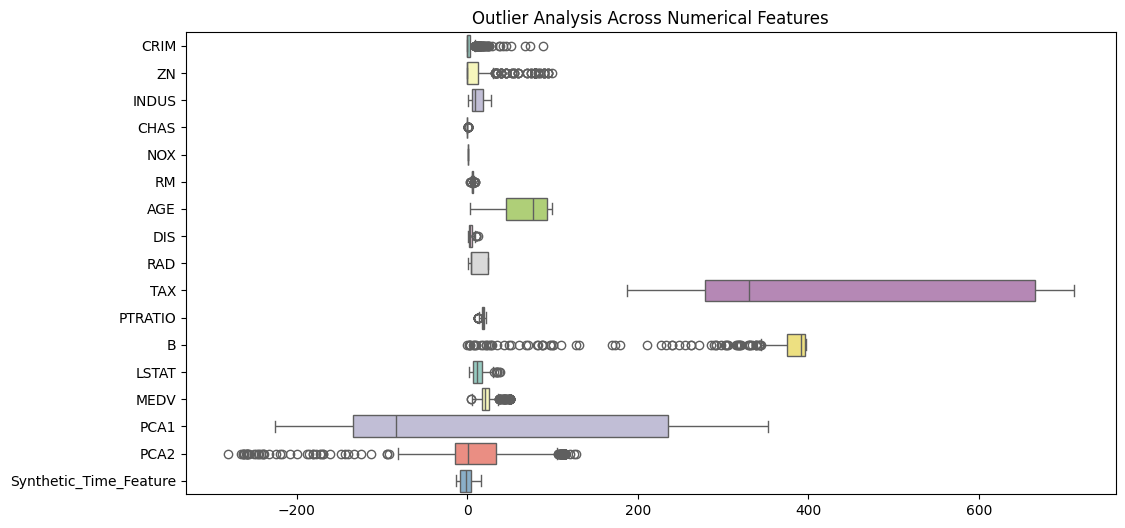

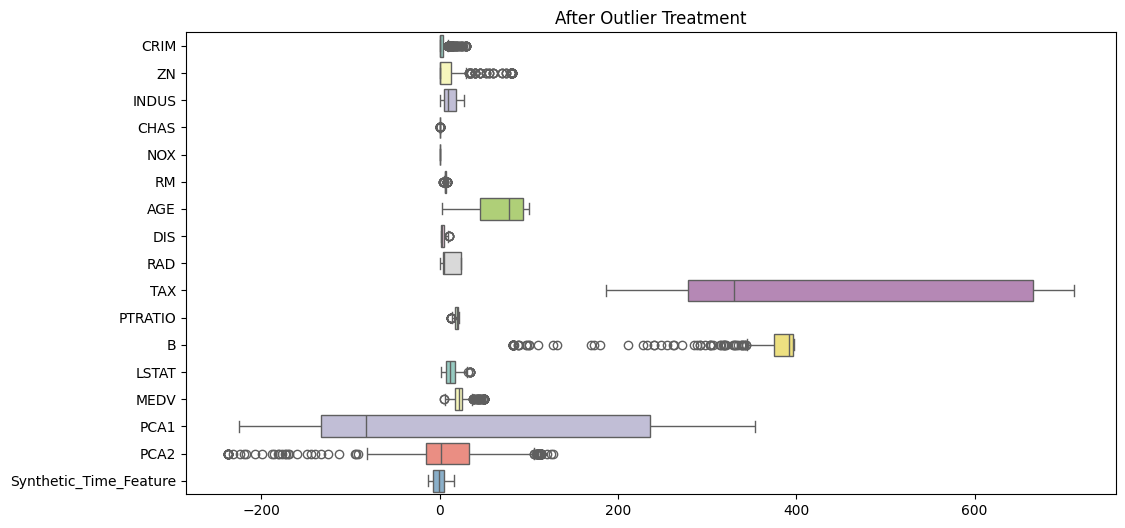

In [34]:
from scipy.stats import zscore

# 2. Quality Investigation: Detecting Outliers Using Z-Score
numerical_data = boston_df.select_dtypes(include=[np.number])
z_scores = numerical_data.apply(zscore)
threshold = 3
outliers = (np.abs(z_scores) > threshold).sum()
print("\nOutliers Detected (Z-Score):")
print(outliers)

# Visualizing Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=numerical_data, orient='h', palette='Set3')
plt.title('Outlier Analysis Across Numerical Features')
plt.show()

# Outlier Treatment: Capping Outliers
capped_data = numerical_data.apply(lambda x: np.where(x > x.mean() + 3*x.std(), x.mean() + 3*x.std(), 
                                                      np.where(x < x.mean() - 3*x.std(), x.mean() - 3*x.std(), x)))

# Visualizing After Outlier Treatment
plt.figure(figsize=(12, 6))
sns.boxplot(data=capped_data, orient='h', palette='Set3')
plt.title('After Outlier Treatment')
plt.show()

We could see a reduction in outliers after capping.

## Dimensionality Reduction: PCA on Numerical Features

A dimension reduction technique that combines correlated variables into a smaller set of uncorrelated variables.

In [26]:
numerical_data = boston_df.select_dtypes(include=[np.number]).drop(columns=['MEDV'])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numerical_data)

boston_df['PCA1'] = pca_result[:, 0]
boston_df['PCA2'] = pca_result[:, 1]

print("\nExplained Variance by PCA Components:")
print(pca.explained_variance_ratio_)


Explained Variance by PCA Components:
[0.80582318 0.16305197]


### PCA results: Visualised

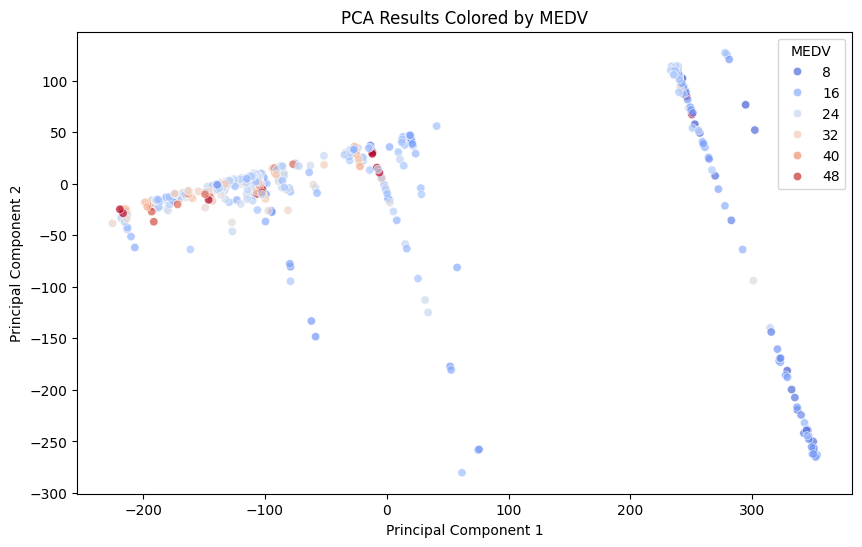

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='MEDV', data=boston_df, palette='coolwarm', alpha=0.7)
plt.title('PCA Results Colored by MEDV')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Lasso for Dimensionality Reduction

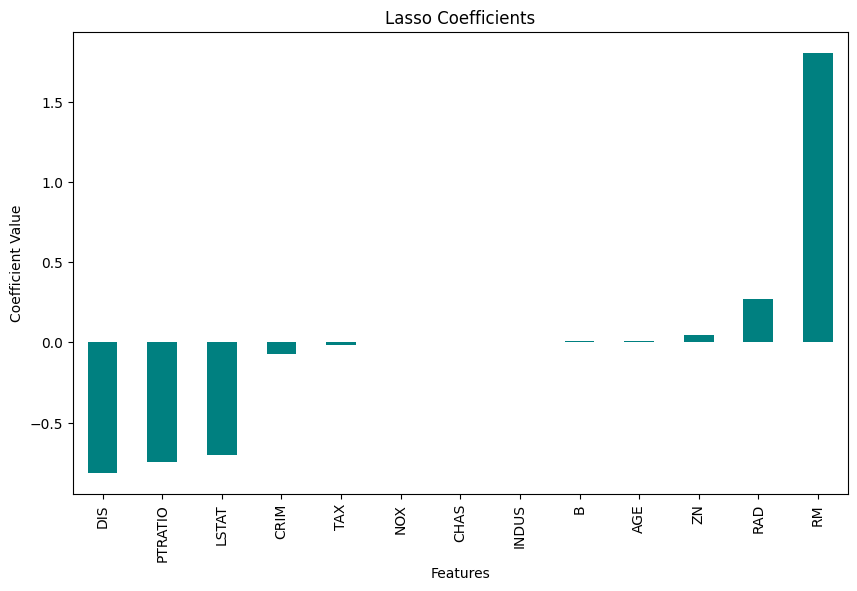


Features Selected by Lasso:
['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [31]:
from sklearn.linear_model import LassoCV

# Lasso for Dimensionality Reduction
lasso = LassoCV(cv=5).fit(numerical_data, boston_df['MEDV'])
lasso_coefficients = pd.Series(lasso.coef_, index=numerical_data.columns)

# Visualizing Lasso Coefficients
plt.figure(figsize=(10, 6))
lasso_coefficients.sort_values().plot(kind='bar', color='teal')
plt.title('Lasso Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

# Selecting Important Features Based on Lasso
selected_features = lasso_coefficients[lasso_coefficients != 0].index.tolist()
print("\nFeatures Selected by Lasso:")
print(selected_features)

## Time Series Analysis

Generating Synthetic time feature for demonstration

In [28]:
np.random.seed(42)
time_series_dates = [datetime(2020, 1, 1) + timedelta(days=i) for i in range(len(boston_df))]
boston_df['Date'] = time_series_dates
boston_df['Synthetic_Time_Feature'] = np.cumsum(np.random.randn(len(boston_df)))

### Plotting the Synthetic time series data on a graph

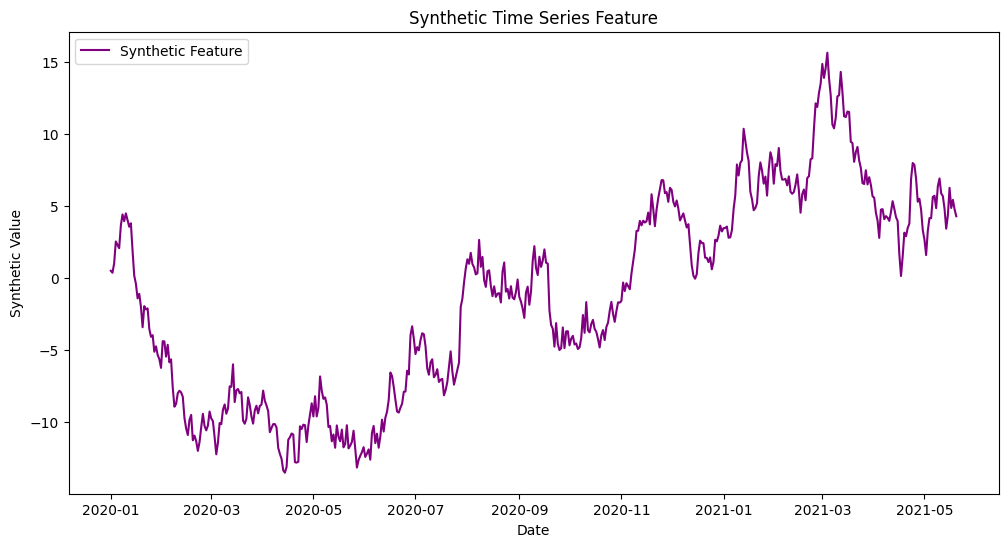

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(boston_df['Date'], boston_df['Synthetic_Time_Feature'], label='Synthetic Feature', color='purple')
plt.title('Synthetic Time Series Feature')
plt.xlabel('Date')
plt.ylabel('Synthetic Value')
plt.legend()
plt.show()

## Seasonal decomposition

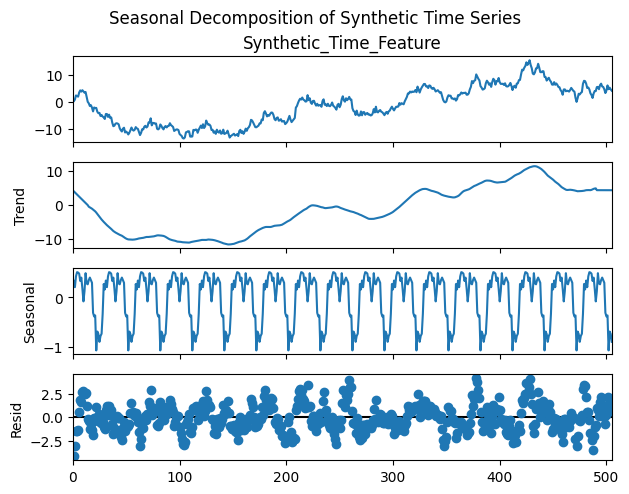

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(boston_df['Synthetic_Time_Feature'], period=30, model='additive', extrapolate_trend='freq')

result.plot()
plt.suptitle('Seasonal Decomposition of Synthetic Time Series', y=1.02)
plt.show()